In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.layers import AveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import glob

In [ ]:
#DNS Images Directories

trainFolder = '/content/drive/My Drive/COVID-CT/DNS/TrainDNS'

In [ ]:
# trainDataLBP = []
# trainLabel = [] #temporary storage
# trainLabelLBP = []

INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BS,
                                                           directory = trainFolder,
                                                           shuffle=True,
                                                           target_size=(255, 255),
                                                           class_mode='categorical',
                                                           subset='training')

validation_data_gen = train_image_generator.flow_from_directory(batch_size=BS,
                                                           directory = trainFolder,
                                                           shuffle=True,
                                                           target_size=(255, 255),
                                                           class_mode='categorical',
                                                           subset='validation')

Found 336 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


In [ ]:
#baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
baseModel = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = GlobalMaxPool2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
# H = model.fit(trainAug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX)/10, validation_data=(testX, testY), validation_steps=len(testX)/10, epochs=10)
H = model.fit(train_data_gen, steps_per_epoch=train_data_gen.samples//BS, validation_data=validation_data_gen, validation_steps=validation_data_gen.samples//BS, epochs = EPOCHS)


[INFO] compiling model...
[INFO] training head...
Epoch 1/25
42/42 [==============================] - 75s 2s/step - loss: 1.4010 - accuracy: 0.5565 - val_loss: 0.5563 - val_accuracy: 0.7125
Epoch 2/25
42/42 [==============================] - 74s 2s/step - loss: 0.7305 - accuracy: 0.6250 - val_loss: 0.6320 - val_accuracy: 0.6125
Epoch 3/25
42/42 [==============================] - 74s 2s/step - loss: 0.6457 - accuracy: 0.6488 - val_loss: 0.6651 - val_accuracy: 0.5500
Epoch 4/25
42/42 [==============================] - 73s 2s/step - loss: 0.6254 - accuracy: 0.6458 - val_loss: 0.6357 - val_accuracy: 0.6250
Epoch 5/25
42/42 [==============================] - 74s 2s/step - loss: 0.6010 - accuracy: 0.6875 - val_loss: 0.5633 - val_accuracy: 0.7125
Epoch 6/25
42/42 [==============================] - 74s 2s/step - loss: 0.5645 - accuracy: 0.7292 - val_loss: 0.5748 - val_accuracy: 0.6875
Epoch 7/25
42/42 [==============================] - 75s 2s/step - loss: 0.5568 - accuracy: 0.7173 - val_loss: 

In [ ]:
avg = (sum(H.history["val_accuracy"])/len(H.history["val_accuracy"]))
avg

0.7115000033378601

In [ ]:
Y_pred = model.predict(validation_data_gen, validation_data_gen.samples // BS+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_data_gen.classes, y_pred))

Confusion Matrix
[[26 20]
 [28  9]]


(0.3, 1.0)

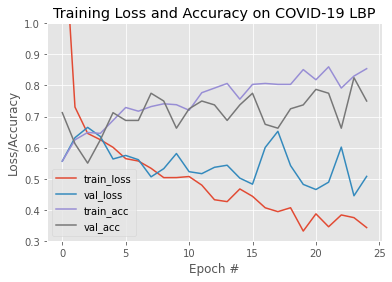

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 LBP")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.ylim(0.3, 1.0)
#plt.savefig(args["plot"])

In [ ]:
#  serialize the model to disk
# print("[INFO] saving COVID-19 detector model...")
# model.save("/content/drive/My Drive/COVID-CT/Models/dnsModel.h5")

[INFO] saving COVID-19 detector model...


In [ ]:
model_json = model.to_json()
with open("/content/drive/My Drive/COVID-CT/Models/dnsModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("dnsModel.h5")
print("Saved model to disk")

Saved model to disk
